# Часть 1. Линейная регрессия

## Задание 1

In [246]:
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')


# загружаем тестовую выборку
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

In [3]:
from sklearn.linear_model import Ridge, Lasso

lasso_clf = Lasso()
ridge_clf = Ridge()

# обучаем со стандартными параметрами
lasso_clf.fit(X_train, y_train)
ridge_clf.fit(X_train, y_train)

lasso_standard_coeffs = lasso_clf.coef_
ridge_standard_coeffs = ridge_clf.coef_

print (lasso_standard_coeffs)
print (ridge_standard_coeffs)

[   0.            0.          274.32681397   48.58596734    0.            0.
   -0.            0.          424.11801795    0.        ]
[  20.86524598  -58.00074047  231.26919104  186.6748608    33.3106947
   -2.16998131 -150.95053633  141.35047981  250.75403183  123.1796716 ]


Будем считать коэффицент "близким к нулю" если по модулю он меньше 10ти. Таким образом имеем 7 для Lasso и 1 для Ridge.

Теперь посмотрим зависимость количества ненулевых коэффицентов от коэффицента регуляризации. Опять же, ненулевыми будут считаться коэффиценты, большие 50ти по модулю.

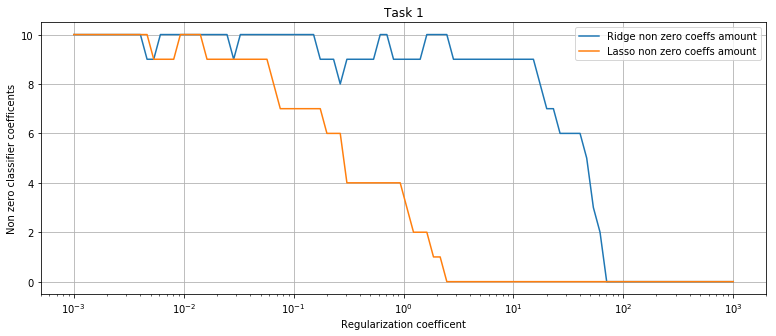

In [10]:
from numpy import logspace
import matplotlib.pyplot as plt

coeffs = logspace(-3, 3, num=100)


ridge_non_zero_coeffs = []
lasso_non_zero_coeffs = []

for i in coeffs: 
    clf1 = Ridge(alpha=i)
    clf2 = Lasso(alpha=i)
    
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    
    ridge_non_zero_coeffs.append(len([k for k in clf1.coef_ if abs(k) >= 10]))
    
    lasso_non_zero_coeffs.append(len([k for k in clf2.coef_ if abs(k) >= 10]))
            
  
graph = plt.figure(figsize=(13, 5))
ax1 = graph.add_subplot(111)

ax1.plot(coeffs, ridge_non_zero_coeffs, label="Ridge non zero coeffs amount")
ax1.plot(coeffs, lasso_non_zero_coeffs, label="Lasso non zero coeffs amount")
ax1.set_title("Task 1")
ax1.set_xlabel("Regularization coefficent")
ax1.set_ylabel("Non zero classifier coefficents")
ax1.grid()
ax1.legend()
plt.xscale('log')

plt.show()
    
    


Посчитаем метрики RMSE, MAE и R2 для Ridge.

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


print (np.sqrt(mean_squared_error(y_test, ridge_clf.predict(X_test))))
print (mean_absolute_error(y_test, ridge_clf.predict(X_test)))
print (r2_score(y_test, ridge_clf.predict(X_test)))

58.3044151277
49.6028460728
0.359899386837


Найдем для Ridge лучший коэффицент регуляризации на каждой из 3ех метрик с помощью GridSearchCV и KFold. Затем построим графики зависимости фукнции потерь от коэффициента регуляризации и посчитаем снова метрики.

In [13]:
from sklearn.model_selection import GridSearchCV, KFold

coeff_range = logspace(-3, 3)

grid1 = GridSearchCV(Ridge(), param_grid={ 'alpha' : coeff_range }, cv=KFold(), scoring='neg_mean_absolute_error')
grid2 = GridSearchCV(Ridge(), param_grid={ 'alpha' : coeff_range }, cv=KFold(), scoring='neg_mean_squared_error')
grid3 = GridSearchCV(Ridge(), param_grid={ 'alpha' : coeff_range }, cv=KFold(), scoring='r2')

grid1.fit(X_train, y_train)
grid2.fit(X_train, y_train)
grid3.fit(X_train, y_train)

print ('MAE', grid1.best_params_)
print ('RMSE', grid2.best_params_)
print ('R2', grid3.best_params_)



MAE {'alpha': 0.039069399370546168}
RMSE {'alpha': 0.0517947467923121}
R2 {'alpha': 0.0517947467923121}


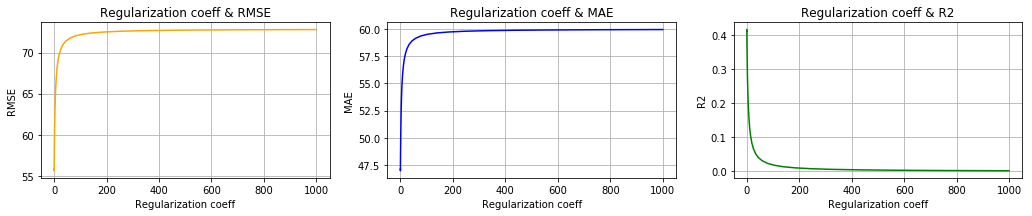

In [16]:
import matplotlib.pyplot as plt


metrics = {"rmse" : [], "mae" : [], "r2" : []}

for param in coeff_range:
    ridge_reg = Ridge(alpha=param)
    ridge_reg.fit(X_train, y_train)
    
    ridge_y_pred = ridge_reg.predict(X_test)
    
    metrics["rmse"].append(np.sqrt(mean_squared_error(y_test, ridge_y_pred)))
    metrics["mae"].append(mean_absolute_error(y_test, ridge_y_pred))
    metrics["r2"].append(r2_score(y_test, ridge_y_pred))

# Draw plot
graph = plt.figure(figsize=(30, 20))


## RMSE
ax1 = plt.subplot(6, 5, 1)
ax1.plot(coeff_range, metrics["rmse"], c="orange")
ax1.set_title("Regularization coeff & RMSE")
ax1.grid(True)
ax1.set_xlabel("Regularization coeff")
ax1.set_ylabel("RMSE")

## MAE
ax2 = plt.subplot(6, 5, 2)
ax2.plot(coeff_range, metrics["mae"], c="blue")
ax2.set_title("Regularization coeff & MAE")
ax2.grid(True)
ax2.set_xlabel("Regularization coeff")
ax2.set_ylabel("MAE")

## R2
ax3 = plt.subplot(6, 5, 3)
ax3.plot(coeff_range, metrics["r2"], c="green")
ax3.set_title("Regularization coeff & R2")
ax3.grid(True)
ax3.set_xlabel("Regularization coeff")
ax3.set_ylabel("R2")

plt.show()

Теперь посмотрим насколько изменилось качество при лучшем коэффицете регуляризации.

In [17]:
clf1 = Ridge(alpha=grid1.best_params_['alpha']) # лучший коэффицент по MAE
clf2 = Ridge(alpha=grid2.best_params_['alpha']) # лучший коэффицент по RMSE
clf3 = Ridge(alpha=grid3.best_params_['alpha']) # лучший коэффицент по R2

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)


print ('RMSE: Standard - {}, with our coef - {}'.format(
                                                np.sqrt(mean_squared_error(y_test, ridge_clf.predict(X_test))),
                                                np.sqrt(mean_squared_error(y_test, clf2.predict(X_test)))
                                            )
                                        )

print ('R2: Standard - {}, with our coef - {}'.format(
                                                r2_score(y_test, ridge_clf.predict(X_test)),
                                                r2_score(y_test, clf3.predict(X_test))
                                            )
                                        )

print ('MAE: Standard - {}, with our coef - {}'.format(
                                                mean_absolute_error(y_test, ridge_clf.predict(X_test)),
                                                mean_absolute_error(y_test, clf1.predict(X_test))
                                            )
                                        )
       
       

RMSE: Standard - 58.304415127748044, with our coef - 55.65981078540739
R2: Standard - 0.3598993868368464, with our coef - 0.41665052927344637
MAE: Standard - 49.60284607275299, with our coef - 47.07355274553301


## Задание 2
### Поиск объектов выбросов

Сделаем Out-Of-Fold предсказание с помощью cross_val_predict на обучающей выборке и посмотрим на распределение ошибок.

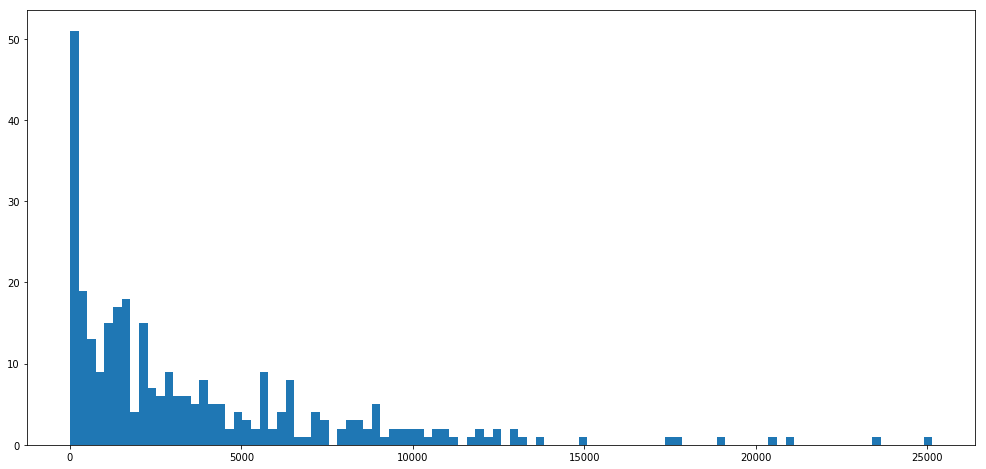

In [9]:
from sklearn.model_selection import cross_val_predict, cross_val_score
import numpy as np

y_pred = cross_val_predict(Ridge(), X_train, y_train)

res = (np.array(y_pred) - np.array(y_train))**2

plt.figure(figsize=(17, 8))

plt.hist(res, bins=100)
plt.show()

Попробуем обучить модель на обучающей выборке с выбросами и без них и сравним качество полученных классификаторов на тестовой выборке. Выбросом будем считать объект с ошибкой, превышающей 10000.

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



res = (np.array(y_pred) - np.array(y_train))**2

# берем только те объекты, ошибка которых меньше 10000
clear_X_train = np.array(X_train)[np.where(res < 10000)]
clear_y_train = np.array(y_train)[np.where(res < 10000)]

clf = Ridge()
clf.fit(X_train, y_train)

clf2 = Ridge()
clf2.fit(clear_X_train, clear_y_train)

# посмотрим стало ли лучше качество на обучающей выборке
print (np.sqrt(abs(cross_val_score(Ridge(), X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())))
print (np.sqrt(abs(cross_val_score(Ridge(), clear_X_train, clear_y_train, cv=10, scoring='neg_mean_squared_error').mean())))

print (np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))) # классификатор, обученный на всей выборке
print (np.sqrt(mean_squared_error(y_test, clf2.predict(X_test)))) # классификатор, обученный на выборке без выбросов

59.5690436915
51.7955903126
58.3044151277
60.1290066719


Заметим, что удалив объекты-выбросы из обучающей выборки, мы хоть и улучшили качество классификатора на ней, однако мы получили худший результат на тестовой выборке. Это может быть связано с тем, что на тестовой выборке объекты-выбросы все еще присутствуют. Таким образом мы немного переобучили модель.

# Часть 2

## Задание 1
### Реализация логистической регрессии с L2 регуляризацией.

In [373]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.special import expit
from sklearn.base import BaseEstimator
from numpy import logaddexp
import time

class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='full',
                 tolerance=1e-6, max_iter=1000, w0=None, alpha=0.001, history=False):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.loss_history = []
        self.iteration_time = []
        self.history = history

    def fit(self, X, y):
        # нормируем матрицу объектов признаков
        X = np.array(X)
        y = np.array(y)

        # инициализируем массив весов
        if self.w0 is not None:
            self.w = self.w0
        else:
            self.w = np.zeros(X[0].size)

        for i in range(self.max_iter):
            from_ = time.time()
            w_new = self.w - self.alpha * self.calc_gradient(X, y)
            
            if self.history:
                time_wasted = time.time() - from_
                self.loss_history.append(self.calc_loss(X, y))
                self.iteration_time.append(time_wasted)
            
            if euclidean(w_new, self.w) < self.tolerance:
                self.w = w_new
                break
                
            self.w = w_new


        return self

    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')

        X = np.array(X)

        predictions = np.empty((2, len(X)))
        t = expit(np.dot(X, self.w))
        predictions[0] = np.ones(len(X)) - t
        predictions[1] = t
        predictions = predictions.T

        return predictions

    def predict(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """

        X = np.array(X)
        if self.w is None:
            raise Exception('Not trained yet')

        predictions = np.zeros(len(X), dtype=int)
        for i in range(len(X)):
            t = expit(np.dot(self.w, X[i]))

            if t > 0.5:
                predictions[i] = 1
            else:
                predictions[i] = 0

        return predictions

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        grad = np.zeros(len(X[0]))
        
        if self.gd_type == 'full':
            grad = np.dot(y * expit(-y * np.dot(X, self.w)), -X)
            grad /= len(X)
        else:
            rand_idx = np.random.randint(0, len(X))
            tmp = y[rand_idx] * X[rand_idx]
            tmp /= -(1 + np.exp(y[rand_idx] * np.dot(self.w, X[rand_idx])))
            grad += tmp
            
            
        grad += self.lambda_2 * self.w

        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float
        """
        total_loss = (np.log(1 / expit(y * (np.dot(X, self.w))))).sum() / len(X)

        total_loss += (self.lambda_2 / 2) * np.linalg.norm(self.w)**2

        return total_loss


Модель успешно прошла тестирование в яндекс-контесте: id посылки - 6730126. Протестируем ее, создав датасет инструментами sklearn и построим графики зависимости функции потерь и затраченного времени от итерации обучения.

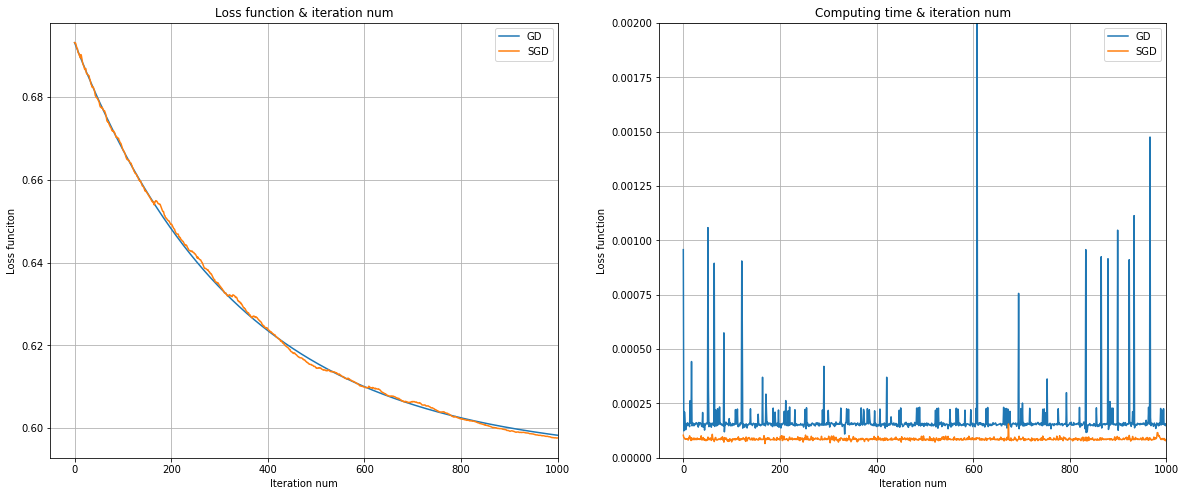

In [193]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


X, y = make_classification(n_samples=500)
y[np.where(y == 0)] = -1

s = StandardScaler()
X = s.fit_transform(X, y)

reg = LogReg(history=True, max_iter=1000)
reg_st = LogReg(gd_type='stohastic', history=True, max_iter=1000)

reg.fit(X, y)
reg_st.fit(X, y)

loss_full = reg.loss_history
loss_st = reg_st.loss_history

it_time_full = reg.iteration_time
it_time_st = reg_st.iteration_time

graph = plt.figure(figsize=(20, 8))

min_iter = min(len(loss_full), len(loss_st))

## loss function
ax1 = plt.subplot(1, 2, 1)
ax1.plot(np.arange(len(loss_full)), loss_full, label='GD')
ax1.plot(np.arange(len(loss_st)), loss_st, label='SGD')
plt.xlim(xmax=min_iter)
ax1.set_title("Loss function & iteration num")
ax1.grid(True)
ax1.set_xlabel("Iteration num")
ax1.set_ylabel("Loss funciton")
ax1.legend()

## computation time
ax2 = plt.subplot(1, 2, 2)
ax2.plot(np.arange(len(loss_full)), it_time_full, label='GD')
ax2.plot(np.arange(len(loss_st)), it_time_st, label='SGD')
plt.xlim(xmax=min_iter)
plt.ylim(ymin=0, ymax=0.002)
ax2.set_title("Computing time & iteration num")
ax2.grid(True)
ax2.set_xlabel("Iteration num")
ax2.set_ylabel("Loss function")
ax2.legend()

plt.show()

Несложно заметить, что график функции потерь GD намного более гладкий, однако затрачиваемое время иногда в разы больше оного для SGD, что может быть невыгодно на крупных выборках.

## Задание 2
### Обучение логистической регрессии на реальных данных и оценка качества классификации.

In [371]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


# download datasets
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

y_train[np.where(y_train == 0)] = -1
y_test[np.where(y_test == 0)] = -1


X_train = np.hstack((X_train, np.ones(X_train.shape[0])[:,np.newaxis])) # добавляем единичный столбец
X_test = np.hstack((X_test, np.ones(X_test.shape[0])[:,np.newaxis])) # добавляем единичный столбец

In [ ]:
# scale features
s = StandardScaler()
X_train = s.fit_transform(X_train, y_train)
X_test = s.transform(X_test)

In [ ]:
reg = LogReg()
reg.fit(X_train, y_train)

y_pred1 = reg.predict_proba(X_test)
y_test1 = np.array(y_test)

Построим precision recall и roc-auc кривые, а также посчитаем average precision score и roc auc score.

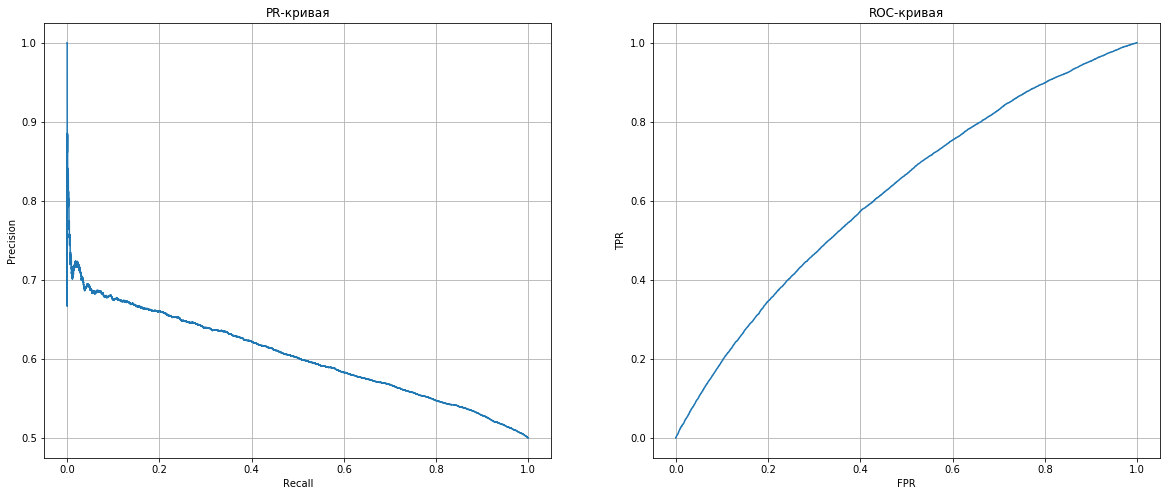

Average precision score: 0.6040577051179983
Roc-auc score: 0.6197147673238927


In [231]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred1[:,1])

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(recall, precision)
plt.grid()
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')

fpr, tpr, _ = roc_curve(y_test, y_pred1[:,1])

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr)
plt.grid()
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

average_precision = average_precision_score(y_test, y_pred1[:,1])
roc_auc = roc_auc_score(y_test, y_pred1[:,1])

print ('Average precision score: {}'.format(average_precision))
print ('Roc-auc score: {}'.format(roc_auc))


In [232]:
indx = np.nonzero(recall >= 0.7)[-1][-1]

thr = thresholds[indx]

print ('Threshold - {}, precision - {}'.format(thr, precision[indx]))

y_pred_copy = np.array(y_pred1)

y_pred_copy[:,1][np.where(y_pred_copy[:,1] >= thr)] = 1
y_pred_copy[:,1][np.where(y_pred_copy[:,1] < thr)] = -1


error_matrix = confusion_matrix(y_test, y_pred_copy[:,1])
print('Матрица ошибок: \n{}'.format(error_matrix))

Threshold - 0.4852925537335726, precision - 0.5677056305137519
Матрица ошибок: 
[[23337 26657]
 [14999 35007]]


## Задание 3
### Влияние регуляризатора на процесс обучения

100%|██████████| 5000/5000 [15:07<00:00,  5.51it/s]


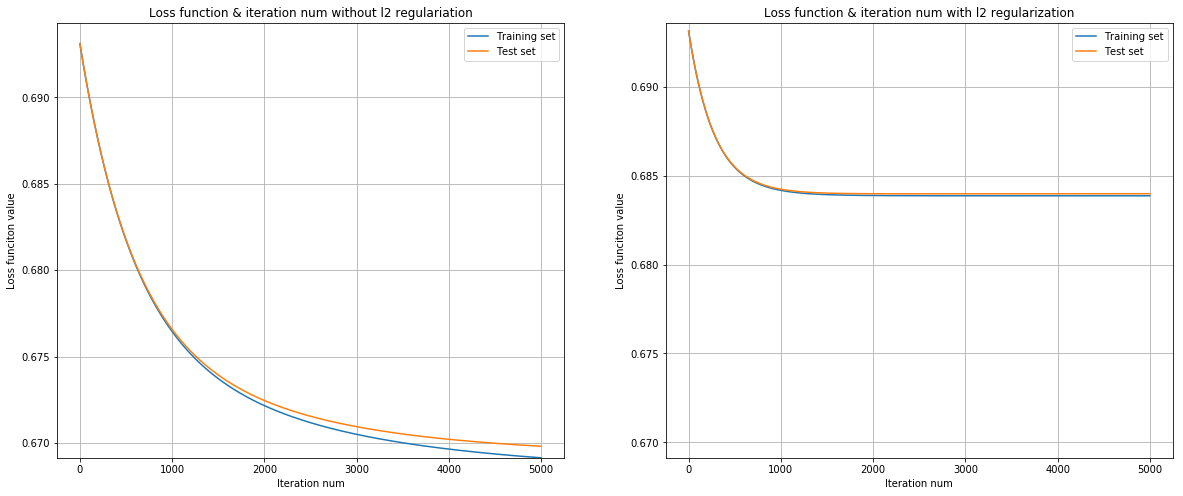

In [188]:
from tqdm import tqdm


l2_w0 = None
zero_l2_w0 = None

l2_train_loss = []
l2_test_loss = []

zero_l2_train_loss = []
zero_l2_test_loss = []

iters_num = 5000

for i in tqdm(range(iters_num)):
    log_reg = LogReg(max_iter=1, w0=l2_w0)
    zero_log_reg = LogReg(lambda_2=0, max_iter=1, w0=zero_l2_w0)
    
    log_reg.fit(X_train, y_train)
    zero_log_reg.fit(X_train, y_train)
    
    l2_train_loss.append(log_reg.calc_loss(X_train, y_train))
    zero_l2_train_loss.append(zero_log_reg.calc_loss(X_train, y_train))
    
    l2_test_loss.append(log_reg.calc_loss(X_test, y_test))
    zero_l2_test_loss.append(zero_log_reg.calc_loss(X_test, y_test))
    
    l2_w0 = log_reg.w
    zero_l2_w0 = zero_log_reg.w
    
min_l2 = min(min(l2_train_loss), min(l2_test_loss))
min_zero_l2 = min(min(zero_l2_test_loss), min(zero_l2_train_loss))
global_min = min(min_l2, min_zero_l2)
    
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Loss function & iteration num without l2 regulariation')
plt.plot(np.arange(iters_num), zero_l2_train_loss, label='Training set')
plt.plot(np.arange(iters_num), zero_l2_test_loss, label='Test set')
plt.legend()
plt.grid()
plt.ylim(ymin=global_min) 
plt.xlabel('Iteration num')
plt.ylabel('Loss funciton value')

plt.subplot(1, 2, 2)
plt.title('Loss function & iteration num with l2 regularization')
plt.plot(np.arange(iters_num), l2_train_loss, label='Training set')
plt.plot(np.arange(iters_num), l2_test_loss, label='Test set')
plt.legend()
plt.grid()
plt.ylim(ymin=global_min) 
plt.xlabel('Iteration num')
plt.ylabel('Loss funciton value')
plt.show()

В модели не использующей l2 регуляризации можно отчетливо увидеть, что значение функции потерь для обучающей выборки продолжает убывать, в то время как для тестовой оно стабилизируется, что сигнализирует о наличии переобучения. В случае же с l2 регуляризацией такого не происходит.

# Часть 3
## Задание 1
### Обучение и применение метода опорных векторов.

In [266]:
from sklearn.svm import LinearSVC

clf = LinearSVC(fit_intercept=False)
clf.fit(X_train, y_train)
y_pred2 = expit(clf.decision_function(X_test))

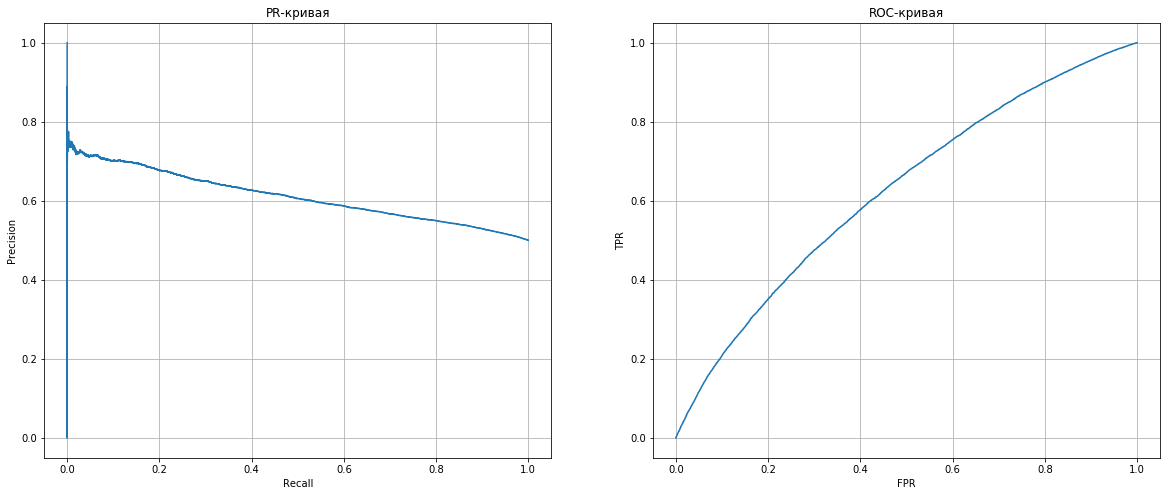

Average precision score: 0.611679185425965
Roc-auc score: 0.6243585249907628


In [267]:
# посчитаем те же метрики что и в предыдущей части
precision, recall, thresholds = precision_recall_curve(y_test, y_pred2)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(recall, precision)
plt.grid()
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')

fpr, tpr, _ = roc_curve(y_test, y_pred2)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr)
plt.grid()
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

average_precision = average_precision_score(y_test, y_pred2)
roc_auc = roc_auc_score(y_test, y_pred2)

print ('Average precision score: {}'.format(average_precision))
print ('Roc-auc score: {}'.format(roc_auc))

Теперь сгенерируем датасет с помощью make_classification с 2мя признаками и обучим на нем метод опорных векторов с линейным ядром. Визуализируем работу модели на тестовой выборке.

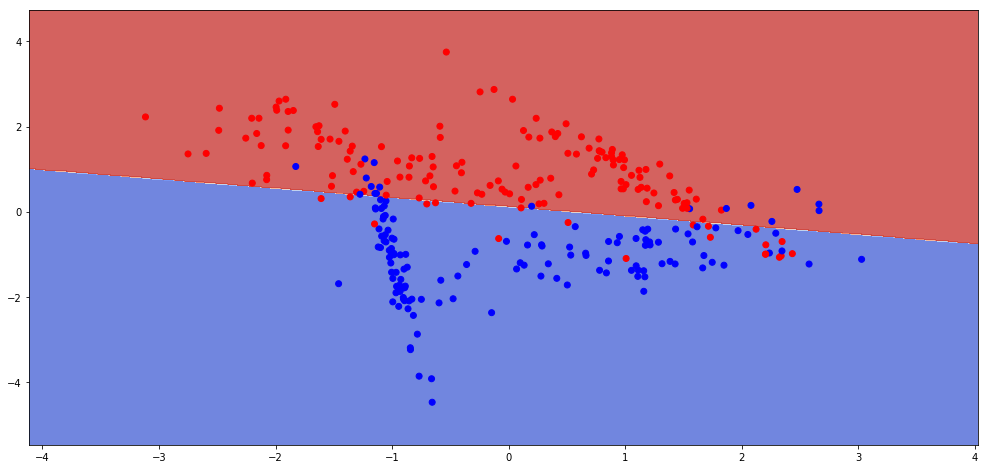

In [370]:
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

cm_bright = ListedColormap(['#0000FF', '#FF0000'])

X_new, y_new = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0)

y_new[np.where(y_new == 0)] = -1

scaler = StandardScaler()
scaler.fit_transform(X_new, y_new)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_new, y_new, test_size=0.3)

clf = SVC(kernel='linear')
clf.fit(X_train3, y_train3)

plot_x = [x[0] for x in X_test3]
plot_y = [x[1] for x in X_test3]

x_min, x_max = min(plot_x) - 1, max(plot_x) + 1
y_min, y_max = min(plot_y) - 1, max(plot_y) + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.figure(figsize=(17, 8))

plt.contourf(xx, yy, z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(plot_x, plot_y, c=y_test3, cmap=cm_bright)

plt.show()

## Задание 2
### Калибровка вероятностей

Займемся оценкой качества выдаваемых алгоритмом вероятностей с помощью калибровочных кривых.

In [243]:
# функция для отрисовки калибровочной кривой
def plot_calibration_curve(y_test, preds, title):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # before: (l - r)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # before: np.min()
        
    plt.figure(figsize=(17, 8))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.title(title)
    plt.grid()
    plt.plot([0, 1], [0, 1], linestyle=':')
    plt.show()

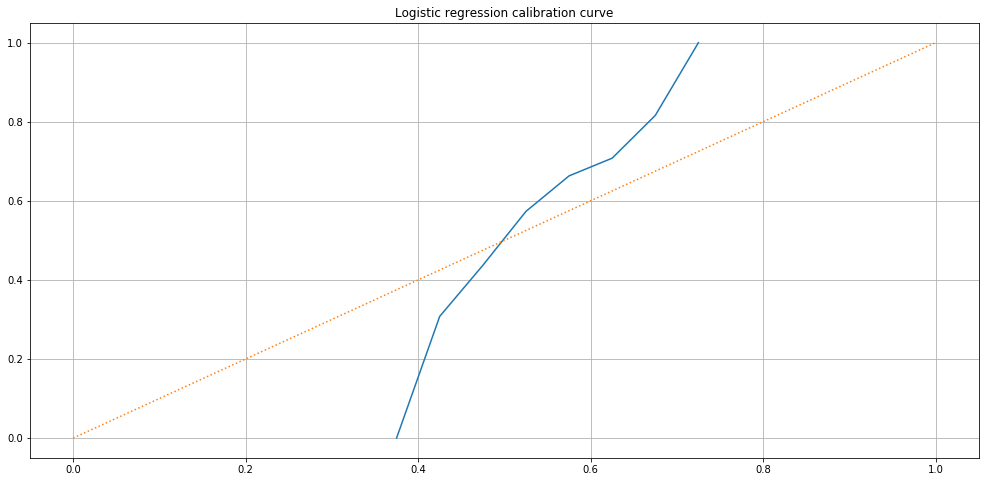

In [268]:
# построим калибровочную кривую для логистической регрессии, реализованной ранее
plot_calibration_curve(y_test1, y_pred1[:,1], "Logistic regression calibration curve")
# set and prediction for train.csv

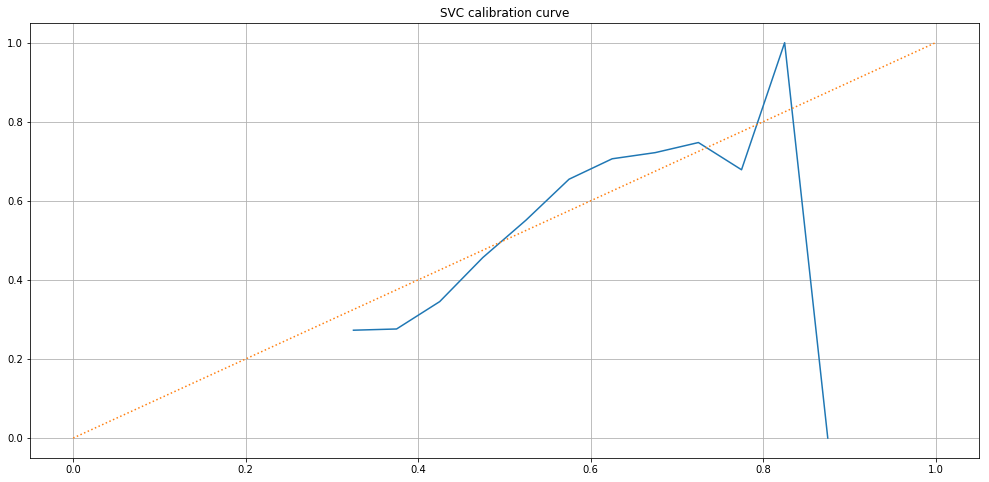

In [269]:
# построим калибровочную кривую для метода опорных векторов, использованного ранее
plot_calibration_curve(y_test1, y_pred2, "SVC calibration curve")
# set and prediction for train.csv

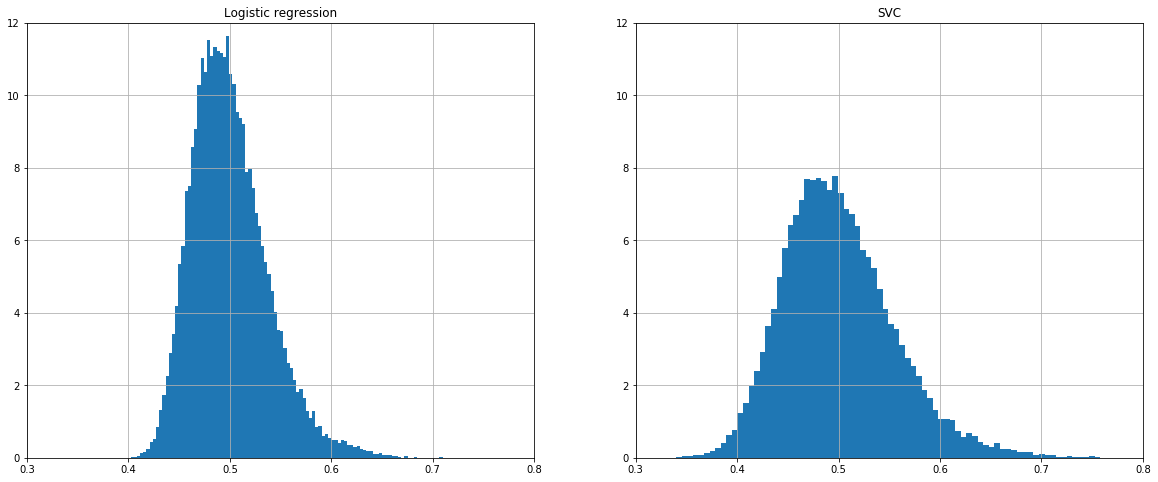

In [272]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.hist(y_pred1[:,1], normed=True, bins=100)
plt.xlim(0.3, 0.8)
plt.ylim(0, 12)
plt.grid()
plt.title('Logistic regression')

plt.subplot(1, 2, 2)
plt.hist(y_pred2, normed=True, bins=100)
plt.xlim(0.3, 0.8)
plt.ylim(0, 12)
plt.grid()
plt.title('SVC')
plt.show()

Построим гистрограммы на 1ом графике для большего удобства.

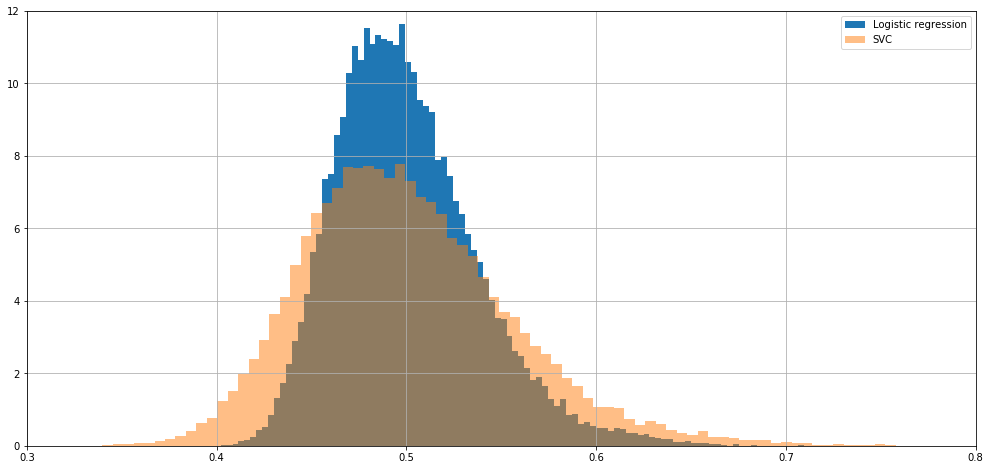

In [278]:
plt.figure(figsize=(17, 8))
plt.hist(y_pred1[:,1], normed=True, bins=100, label='Logistic regression')
plt.hist(y_pred2, normed=True, bins=100, label='SVC', alpha=0.5)
plt.grid()
plt.legend()
plt.xlim(0.3, 0.8)
plt.ylim(0, 12)
plt.show()


Заметим, что распределение вероятностей у метода опорных векторов более плавное, чем у логистической регрессии. Откалибруем метод опорных векторов с помощью CalibratedClassifierCV из sklearn.

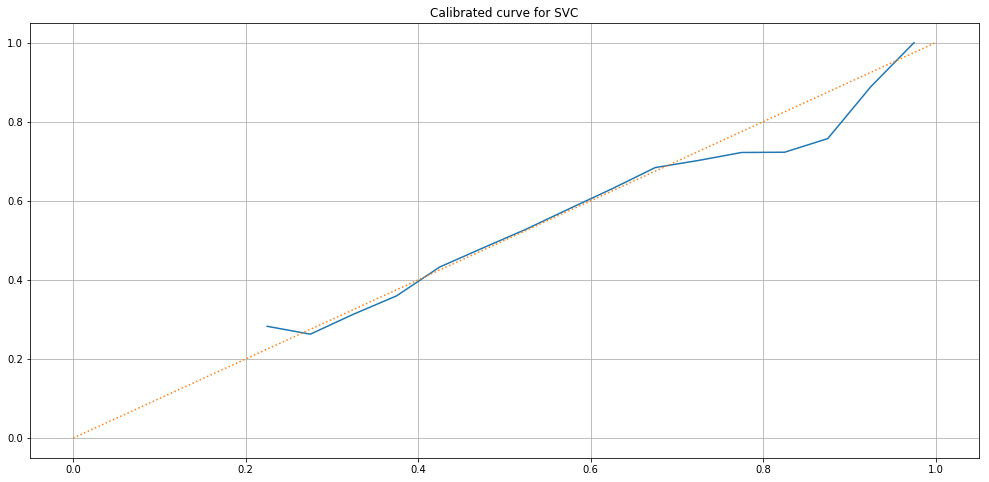

In [281]:
from sklearn.calibration import CalibratedClassifierCV as CCV

# X and y from train.csv
ccv_clf = CCV(LinearSVC(fit_intercept=False))
ccv_clf.fit(X_train, y_train)
y_pred_ccv = ccv_clf.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, y_pred_ccv, title='Calibrated curve for SVC')

Калибровочная кривая заметно улучшилась, что говорит об улучшении качества предсказания.

# Часть 4
## Задание 1
### Работа с категориальными признаками. One-hot кодирование.

In [374]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler

s = StandardScaler(with_mean=False)

# data from train.csv
header = list(data.columns.values)
cat_indices = []

for i in range(len(header)):
    if 'cat' in header[i]:
        cat_indices.append(i)

# смотрим, есть ли в выборке отрицательные категории. Если да, то увеличиваем значени всех категорий на 1
# так как нам на самом деле не важно конкретное значение
while (X_train[:, cat_indices] < 0).any() or (X_test[:, cat_indices] < 0).any():
    X_train[:, cat_indices] += 1
    X_test[:, cat_indices] += 1


# Кодируем One-Hot
enc_train = OneHotEncoder(categorical_features=cat_indices)
X_train_encoded = enc_train.fit_transform(X_train).toarray()
X_test_encoded = enc_train.transform(X_test).toarray()

X_train_encoded = s.fit_transform(X_train_encoded)
X_test_encoded = s.transform(X_test_encoded)

from_ = time.time()
log_reg = LogReg()
log_reg.fit(X_train_encoded, y_train)
y_pred_OHE = log_reg.predict_proba(X_test_encoded)
log_reg_time = time.time() - from_

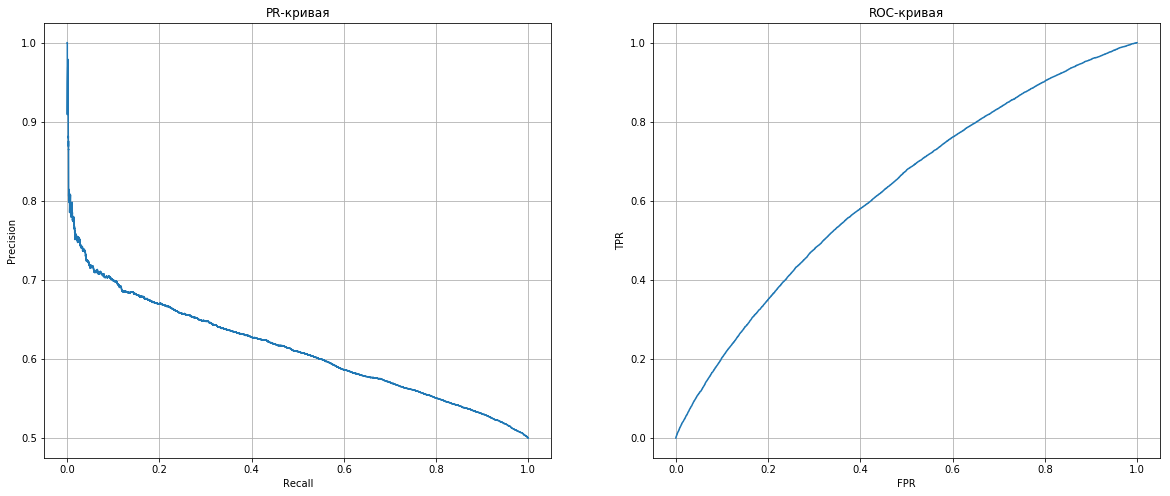

Computing time: 161.6120433807373
Average precision score: 0.6129772445076661
Roc-auc score: 0.6259775306140765


In [375]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_OHE[:, 1])

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(recall, precision)
plt.grid()
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')

fpr, tpr, _ = roc_curve(y_test, y_pred_OHE[:, 1])

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr)
plt.grid()
plt.title('ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

average_precision = average_precision_score(y_test, y_pred_OHE[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_OHE[:, 1])

print ('Computing time: {}'.format(log_reg_time))
print ('Average precision score: {}'.format(average_precision))
print ('Roc-auc score: {}'.format(roc_auc))

Имеем незначительный прирост в качестве предсказания, однако вместе с тем очень сильное увеличение времени обучения модели, т.к one-hot кодирование увеличивает количество признаков, что влияет на время, требуемое FGD.

# Часть 5
## Особенности и возможности Vowpal Wabbit

1. С помощью хеширования признаков (hashing trick) можно обучать модели с большим количеством весов, которые могут не вместиться в память.

2. Библиотека предоставляет возможность распределенного обучения, при котором оно будет распараллелено на нескольно машин.

3. Возможность "Онлайн-обучения". Библиотека позволяет работать с огромным количеством данных, т.к не требует их выгрузки в RAM за счет использования стохастического оптимизатора.

4. Использования многоядерных машин - обработка входных данных производится в независимых потоках.

